# Predicting Recessions
## Business Cylces
- Economies go through expansions and recessions
- Expansion
    - Periods of growth in GDP
- Recessions
    - Periods of GDP decline
    - Recessions are generally defined as two quarters of decline in GDP
- We saw earlier how yield curves historically have inverted before recessions
- Now let us try to use more predictors to see if we can predict recessions

- Why should we do this?
    - Predicting Recessions better than the stock market will be very profitable for investors
    - Policy makers can take appropriate action

- In last lecture we saw machine learning is essentially figuring out the f in 
$$ Y = f(X) + e $$
- In our task what is Y?
- Is that a quantitative or qualitative variable?
- Is this a regression or classification problem?

- What predictors can we use (X)?
- Yield curve
    - Spread between 10 year treasury yield and 2 year treasury yield
- Unemployment rate
- Change in Inventory
- New Housing Permits
- Percentage change in housing prices
- Percentage change in retail sales
- Data source: FRED

In [23]:
# Import Datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

import pandas_datareader.data as web
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Import Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Import export_graphviz
from sklearn.tree import export_graphviz

import seaborn as sn

# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Import Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

- Symbols for getting the data from FRED
- 10 and 2 year spread - T10Y2Y
- Unemployment rate - UNRATE
- Change in Inventory - CBIC1
- New Housing Permits - PERMIT
- Housing prices - USSTHPI
- Retail sales - SLRTTO01USQ661S
    - For housing prices and retail sales need to compute percentage change in retail sales

In [2]:
# Extract Predictors 
Predictors=web.DataReader(["T10Y2Y", "UNRATE", "CBIC1", "PERMIT","USSTHPI", "SLRTTO01USQ661S"], "fred", "1976-01-01", "2022-12-31")
Predictors

,T10Y2Y,UNRATE,CBIC1,PERMIT,USSTHPI,SLRTTO01USQ661S
DATE,,,,,,
1976-01-01,NaN,7.9,40.608,1195.0,62.89,52.835884
1976-02-01,NaN,7.7,NaN,1190.0,NaN,NaN
1976-03-01,NaN,7.6,NaN,1164.0,NaN,NaN
1976-04-01,NaN,7.7,61.087,1132.0,65.45,53.606131
1976-05-01,NaN,7.4,NaN,1194.0,NaN,NaN
...,...,...,...,...,...,...
2022-12-26,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.48,NaN,NaN,NaN,NaN,NaN
2022-12-28,-0.43,NaN,NaN,NaN,NaN,NaN


In [7]:
QtrPreds=Predictors.resample('QS').mean()
QtrPreds.columns=['Yield', 'Unemp', 'C_Inv', 'Permit', 'House', 'Retail']
QtrPreds['C_House']=(QtrPreds['House']/QtrPreds['House'].shift(4))-1
QtrPreds['C_Retail']=(QtrPreds['Retail']/QtrPreds['Retail'].shift(4))-1
QtrPreds_1=QtrPreds.drop(['House', 'Retail'], axis=1).dropna()
QtrPreds_1

,Yield,Unemp,C_Inv,Permit,C_House,C_Retail
DATE,,,,,,
1977-01-01,1.332222,7.500000,34.343,1562.000000,0.104945,0.037939
1977-04-01,1.248254,7.133333,51.245,1693.333333,0.111230,0.032931
1977-07-01,0.814762,6.900000,89.947,1713.666667,0.117523,0.034861
1977-10-01,0.454833,6.666667,47.311,1761.000000,0.147977,0.038371
1978-01-01,0.466393,6.333333,56.354,1758.333333,0.145201,0.016099
...,...,...,...,...,...,...
2017-04-01,0.963333,4.366667,17.408,1268.333333,0.056358,0.022948
2017-07-01,0.878730,4.333333,86.688,1280.666667,0.053898,0.024696
2017-10-01,0.677097,4.166667,52.294,1314.666667,0.054447,0.037249


- The variable we are trying to predict is whether or not the economy is in a recession

In [10]:
# Get Recession dates
Recession=web.DataReader(["USRECQ"],"fred","1977-01-01","2022-12-31")
Recession[Recession['USRECQ']==1]

,USRECQ
DATE,
1980-04-01,1
1980-07-01,1
1981-10-01,1
1982-01-01,1
1982-04-01,1
1982-07-01,1
1982-10-01,1
1990-10-01,1
1991-01-01,1


In [11]:
Recession

,USRECQ
DATE,
1977-01-01,0
1977-04-01,0
1977-07-01,0
1977-10-01,0
1978-01-01,0
...,...
2021-10-01,0
2022-01-01,0
2022-04-01,0


In [13]:
#Create a third data frame that combines our X and y dataframes
#Want to lag the X dataframe by 1 quarter
alldata=QtrPreds_1.shift(1).dropna()
alldata['Recession']=Recession['USRECQ']
alldata

,Yield,Unemp,C_Inv,Permit,C_House,C_Retail,Recession
DATE,,,,,,,
1977-04-01,1.332222,7.500000,34.343,1562.000000,0.104945,0.037939,0
1977-07-01,1.248254,7.133333,51.245,1693.333333,0.111230,0.032931,0
1977-10-01,0.814762,6.900000,89.947,1713.666667,0.117523,0.034861,0
1978-01-01,0.454833,6.666667,47.311,1761.000000,0.147977,0.038371,0
1978-04-01,0.466393,6.333333,56.354,1758.333333,0.145201,0.016099,0
...,...,...,...,...,...,...,...
2017-04-01,1.202258,4.566667,-11.353,1278.000000,0.052611,0.023672,0
2017-07-01,0.963333,4.366667,17.408,1268.333333,0.056358,0.022948,0
2017-10-01,0.878730,4.333333,86.688,1280.666667,0.053898,0.024696,0


- We want to see whether the data from one quarter
    - can predict the recession in the next quarter
- We are interested in 
$$ Y_{t+1}=f(X_{t})+e_{t+1}$$
- where t represents the quarters
- We can do that either by lagging the predictors by one quarter

In [14]:
alldata['Recession'].mean()

0.10909090909090909

In [15]:
X=alldata.drop(['Recession'], axis=1).copy()
y=alldata['Recession'].copy()

In [18]:
X

,Yield,Unemp,C_Inv,Permit,C_House,C_Retail
DATE,,,,,,
1977-04-01,1.332222,7.500000,34.343,1562.000000,0.104945,0.037939
1977-07-01,1.248254,7.133333,51.245,1693.333333,0.111230,0.032931
1977-10-01,0.814762,6.900000,89.947,1713.666667,0.117523,0.034861
1978-01-01,0.454833,6.666667,47.311,1761.000000,0.147977,0.038371
1978-04-01,0.466393,6.333333,56.354,1758.333333,0.145201,0.016099
...,...,...,...,...,...,...
2017-04-01,1.202258,4.566667,-11.353,1278.000000,0.052611,0.023672
2017-07-01,0.963333,4.366667,17.408,1268.333333,0.056358,0.022948
2017-10-01,0.878730,4.333333,86.688,1280.666667,0.053898,0.024696


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, random_state=123)

In [21]:
print(len(y_train), len(y_test))

123 42


- In the data recession was coded as 1 and expansion as 0
- So rather than a linear regression, we should use a Logistic model, which gives a probability that a particular event happens (restricted to be between 0 and 1)

In [26]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train, y_train)
logpred_test=model.predict(X_test)

In [28]:
#What percent of predictions are accurate?
(logpred_test==y_test).mean()

0.9285714285714286

In [29]:
model.score(X_test,y_test)

0.9285714285714286

# k Nearest Neighbors

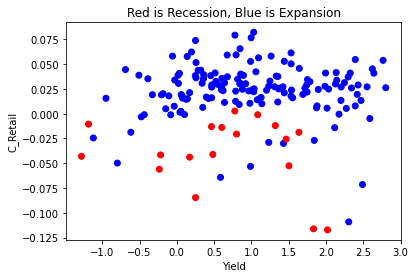

In [30]:
c=np.array(['k']*len(y))
for i in range(len(y)):
    if y[i]==1:
        c[i]='r'
    else:
        c[i]='b'
plt.scatter(X['Yield'], X['C_Retail'], color=c)
plt.xlabel('Yield')
plt.ylabel('C_Retail')
plt.title('Red is Recession, Blue is Expansion')
plt.show()

In [37]:
model=KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)
trainpred=model.predict(X_train)
testpred=model.predict(X_test)

In [38]:
model.score(X_train, y_train)

0.926829268292683

In [39]:
model.score(X_test, y_test)

0.9047619047619048

# Task

Tryout different kNearest Neighbors (by changing no of neighbors)
1. Does the training score improve?
2. Does the testing score improve?

In [40]:
N=50
train_score=np.zeros(N)
test_score=np.zeros(N)

for i in range(1,N+1):
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    train_score[i-1]=model.score(X_train, y_train)
    test_score[i-1]=model.score(X_test, y_test)

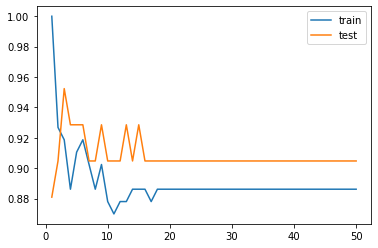

In [41]:
plt.plot(range(1,N+1), train_score, label='train')
plt.plot(range(1,N+1), test_score, label='test')
plt.legend()
plt.show()

## Decision Trees

In [42]:
model=DecisionTreeClassifier()
model.fit(X_train,y_train)
model.score(X_train,y_train)

1.0

In [43]:
model.score(X_test,y_test)

0.9047619047619048

In [44]:
# Visualize the tree
# Import export_graphviz
from sklearn.tree import export_graphviz
# build
export_graphviz(model, out_file="tree.dot", class_names=["Expansion","Recession"], feature_names=X.columns, impurity=False, filled=True)

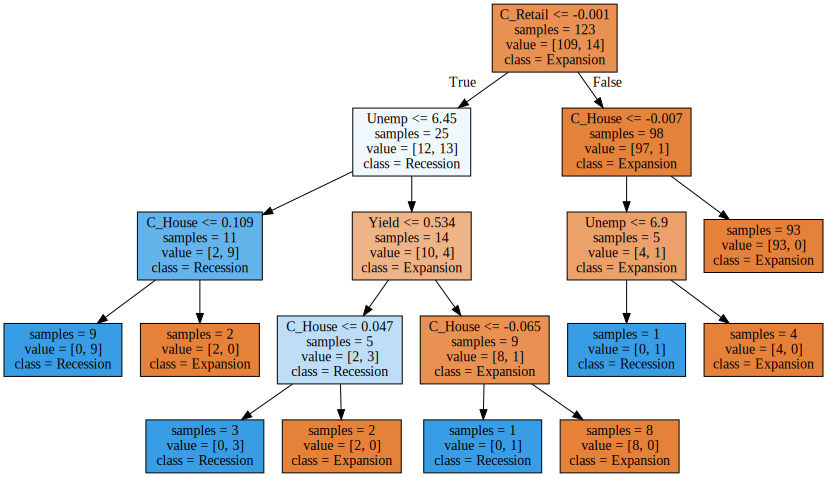

In [45]:
# Show
import graphviz

with open("tree.dot") as file:
    decision_tree=file.read()
graphviz.Source(decision_tree)

In [46]:
# Set Maximum depth to 1
model=DecisionTreeClassifier(max_depth=1)
# fit the model
model.fit(X_train,y_train)
# Training and testing accurace
model.score(X_train,y_train),model.score(X_test,y_test)

(0.8943089430894309, 0.9523809523809523)

In [47]:
export_graphviz(model, out_file="tree1.dot", class_names=["Expansion","Recession"], feature_names=X.columns, impurity=False, filled=True)

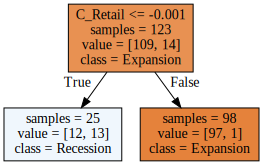

In [48]:
with open("tree1.dot") as file:
    decision_tree=file.read()
graphviz.Source(decision_tree)

# Random Forests
- Ensembles
    - Methods that combine multiple machine learning models to create powerful models

- The problem with decision trees is that they tend to overfit training data
- Random Forests
    - Collection of decision trees
    - Each tree might overfit data
    - By building many trees and averaging them reduce overfitting
- How to randomize trees
    - Selecting data points
    - selecting features
- Process
    - We can sample the training data multiple times
    - In each node, instead of looking at best features
        - The algorithm randomly sample features
        - Looks for best features in the subset
    - This way all the trees in the forest can be different
    - We can choose a maximum limit on the features that is being used
        - If we choose low number of features, each tree will be different but not deep
        - if we choose high number of features, trees will be similar but will be able to fit the data well
    - Prediction
        - Each tree will provide a probability
        - Average of all trees' probability is taken and prediction is made 
        
    


In [52]:
model=RandomForestClassifier(n_estimators=5, random_state=123)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test,y_test)

(1.0, 0.9285714285714286)

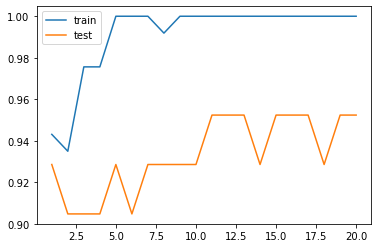

In [53]:
N=20
train_score=np.zeros(N)
test_score=np.zeros(N)

for i in range(1,N+1):
    model=RandomForestClassifier(n_estimators=i, random_state=123)
    model.fit(X_train, y_train)
    train_score[i-1]=model.score(X_train, y_train)
    test_score[i-1]=model.score(X_test, y_test)
plt.plot(range(1,N+1), train_score, label='train')
plt.plot(range(1,N+1), test_score, label='test')
plt.legend()
plt.show()

# Gradient Boosting
- Ensemble method
- Build trees in serial manner
    - Each tree tries to correct mistakes of the previous one
    - Shallow trees with depth of 1-5
    - Combine many simple models
    - Each tree provides good predictions on part of the data
- More sensitive to parameter setting

In [56]:
model=GradientBoostingClassifier(max_depth=3, n_estimators=8, random_state=123)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test,y_test)

(0.967479674796748, 0.8571428571428571)

#### Do a grid search of the number of trees in the forest (n_estimators) to find "sweet spot" that maximizes model test score

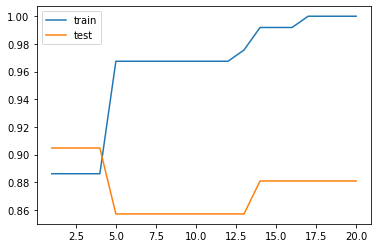

In [57]:
N=20
train_score=np.zeros(N)
test_score=np.zeros(N)

for i in range(1,N+1):
    model=GradientBoostingClassifier(max_depth=3, n_estimators=i, random_state=123)
    model.fit(X_train, y_train)
    train_score[i-1]=model.score(X_train, y_train)
    test_score[i-1]=model.score(X_test, y_test)
plt.plot(range(1,N+1), train_score, label='train')
plt.plot(range(1,N+1), test_score, label='test')
plt.legend()
plt.show()